# Artificial Neural Network

### Setup

In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from utils_io import load_step, save_step
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from scipy.stats import randint, loguniform

In [2]:
y_train = load_step("y_train_nz")
y_test = load_step("y_test_nz")
X_train_scaled = load_step("X_train_nz_scaled")
X_test_scaled = load_step("X_test_nz_scaled")

### Initialize Model

In [3]:
# Make sure y is 1D (your existing code)
y_train_arr = np.ravel(y_train)

# Base ANN (only keep things FIXED that we do NOT tune)
ann_base = MLPRegressor(
    hidden_layer_sizes=(64, 32),   # will be overwritten by search
    activation="relu",             # will be overwritten by search
    solver="adam",                 # keep fixed: good default for large data
    alpha=1e-3,                    # will be overwritten by search
    learning_rate="adaptive",      # will be overwritten by search
    learning_rate_init=1e-3,       # will be overwritten by search
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

### Hyperparameter Optimization

In [4]:

# --- RANDOM SEARCH SPACE ---

param_distributions = {
    # network depth & width (capacity)
    "hidden_layer_sizes": [
        (32,), (64,), (128,),           # shallow, single layer
        (64, 32), (128, 64),            # like your current + bigger
        (128, 64, 32), (256, 128, 64)   # deeper & wider (aggressive)
    ],
    
    # activation: how nonlinear the network can be
    "activation": ["relu", "tanh"],
    
    # L2 regularization: controls overfitting of weights
    # loguniform -> each order of magnitude equally likely
    "alpha": loguniform(1e-5, 1e1),   # 10⁻⁶ … 10⁻¹
    
    # initial learning rate for Adam
    "learning_rate_init": loguniform(1e-4, 1e-1),  # 10⁻⁴ … 10⁻¹
    
    # learning rate schedule: stable vs. more flexible
    "learning_rate": ["constant", "adaptive"],
    
    # batch size: influences noise in gradient & speed
    "batch_size": [64, 128, 256, 512]
}

# CV like in your other models
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ann_random_search = RandomizedSearchCV(
    estimator=ann_base,
    param_distributions=param_distributions,
    n_iter=50,  # can increase to 100 if you have time/compute
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Running Random Search for ANN (MLPRegressor)...")
ann_random_search.fit(X_train_scaled, y_train_arr)

print("\nBest parameters (ANN):")
print(ann_random_search.best_params_)
print(f"Best CV MSE (negative): {ann_random_search.best_score_:.4f}")

Running Random Search for ANN (MLPRegressor)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END activation=relu, alpha=0.004731474644815001, batch_size=256, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0396760507705299; total time=   2.1s
[CV] END activation=relu, alpha=0.004731474644815001, batch_size=256, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0396760507705299; total time=   2.6s
[CV] END activation=relu, alpha=0.004731474644815001, batch_size=256, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0396760507705299; total time=   3.1s
[CV] END activation=relu, alpha=0.004731474644815001, batch_size=256, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0396760507705299; total time=   3.6s
[CV] END activation=relu, alpha=0.004731474644815001, batch_size=256, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0396760507705299; total time=   

### Train Optimized ANN

In [5]:
y_test_arr = np.ravel(y_test)

# Train final model on full training data with best params (optional but recommended)
best_ann = ann_random_search.best_estimator_
best_ann.fit(X_train_scaled, y_train_arr)

# Evaluate on test data
y_pred_ann = best_ann.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse_ann = mean_squared_error(y_test_arr, y_pred_ann)
r2_ann = r2_score(y_test_arr, y_pred_ann)
print(f"\nANN (best hyperparams) MSE: {mse_ann:.2f}")
print(f"ANN (best hyperparams) R²: {r2_ann:.3f}")

mse_ann = mean_squared_error(y_test_arr, y_pred_ann)
mae_ann = mean_absolute_error(y_test_arr, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_arr, y_pred_ann)

print("\nArtificial Neural Network (MLPRegressor)")
print(f"MAE :  {mae_ann:.4f}")
print(f"RMSE:  {rmse_ann:.4f}")
print(f"R^2 :  {r2_ann:.4f}")


ANN (best hyperparams) MSE: 231.29
ANN (best hyperparams) R²: 0.290

Artificial Neural Network (MLPRegressor)
MAE :  11.7289
RMSE:  15.2082
R^2 :  0.2904


### Plot Optimized ANN

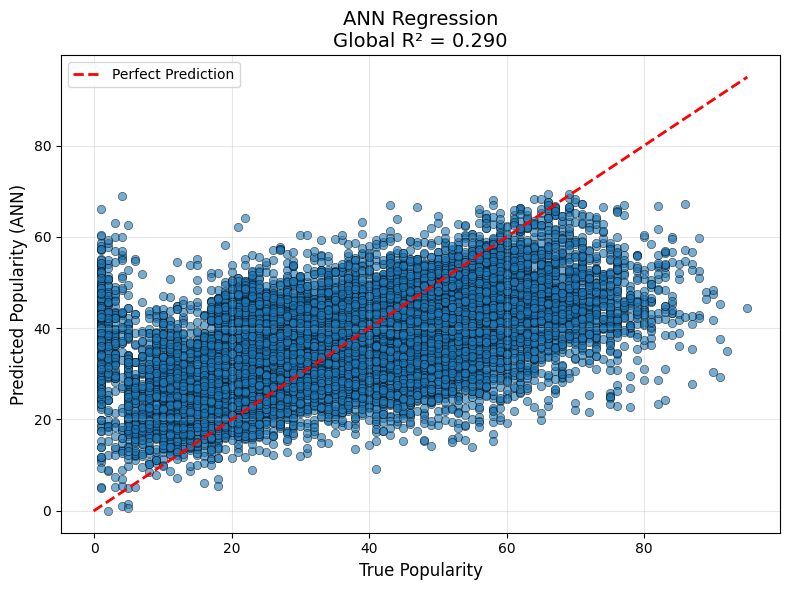

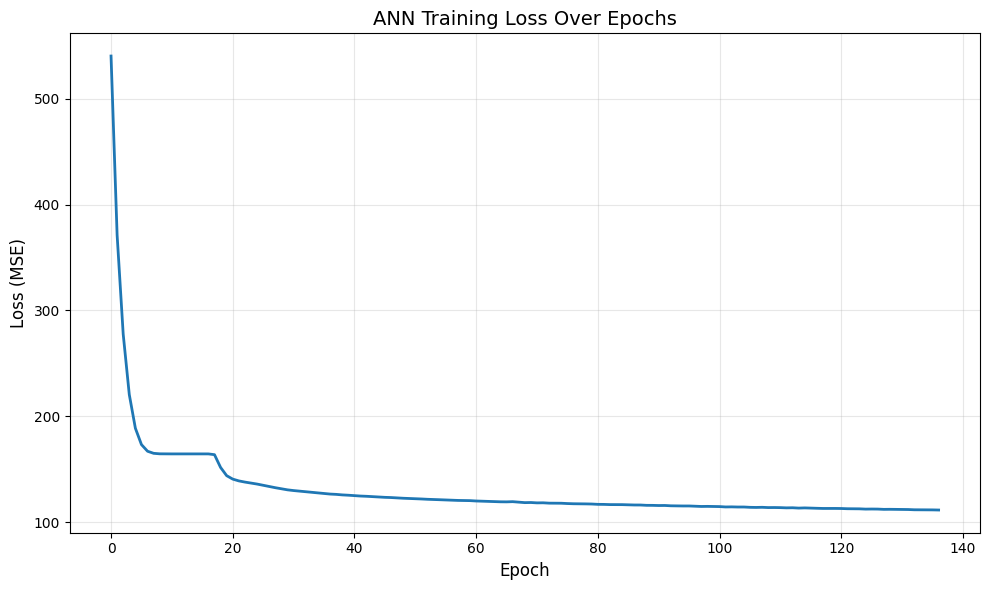

In [7]:
# VISUALIZATION: Predicted vs Actual

plt.figure(figsize=(8, 6))
plt.scatter(y_test_arr, y_pred_ann, alpha=0.6, edgecolors="k", linewidth=0.5)
min_val = min(y_test_arr.min(), y_pred_ann.min())
max_val = max(y_test_arr.max(), y_pred_ann.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect Prediction")
plt.xlabel("True Popularity", fontsize=12)
plt.ylabel("Predicted Popularity (ANN)", fontsize=12)
plt.title(f"ANN Regression\nGlobal R² = {r2_ann:.3f}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# VISUALIZATION: Training Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(best_ann.loss_curve_, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('ANN Training Loss Over Epochs', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
